# Mava Quickstart Notebook



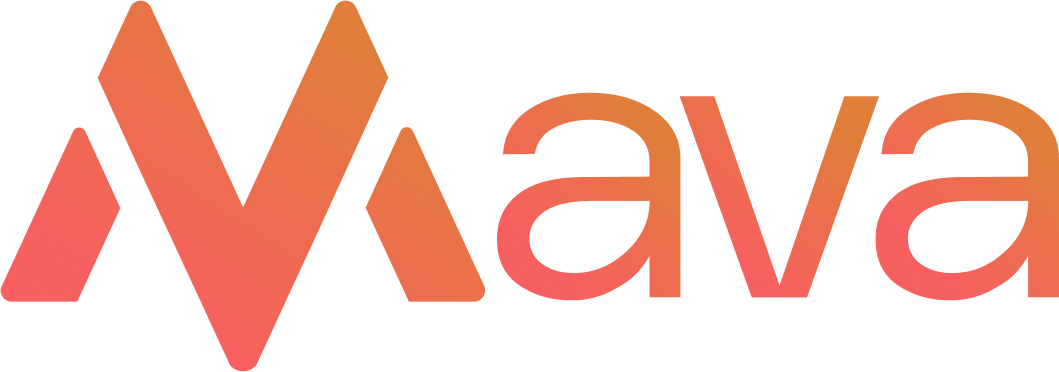

### This notebook offers a simple introduction to [Mava](https://github.com/instadeepai/Mava) by showing how to build and train a multi-agent PPO (MAPPO) system on the RobotWarehouse environment from [Jumanji](https://github.com/instadeepai/jumanji). Mava follows the design philosophy of [CleanRL](https://github.com/vwxyzjn/cleanrl) allowing for easy code readability and reuse, and is built on top of code from [PureJaxRL](https://github.com/luchris429/purejaxrl), extending it to provide end-to-end JAX-based multi-agent algorithms.

<a href="https://colab.research.google.com/github/instadeepai/Mava/blob/develop/examples/Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Requirements

We start by installing and importing the necessary packages.

> Note: Please anticipate a short delay while installing the requirements. Downgrading JAX to version `0.4.13` requires CUDA re-configuration for proper GPU detection in Colab. This setup may take a few minutes.

In [3]:
%%capture
# @title Install Mava
! pip install git+https://github.com/instadeepai/mava.git@develop
! pip install "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Restarting the runtime is necessary after reinstalling JAX in Colab to ensure that the changes take effect and that the runtime environment is properly configured for the updated JAX version.

In [ ]:
# @title Restart Google Colab runtime
import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Import required packages.

from typing import Any, Callable, Dict, Sequence, Tuple
from colorama import Fore, Style

import optax
from optax._src.base import OptState
import chex
import distrax
import flax.linen as nn
from flax import struct
from flax.core.frozen_dict import FrozenDict
from flax.linen.initializers import constant, orthogonal
import jax
import jax.numpy as jnp
import numpy as np

# Env requirements
import jumanji
from jumanji.env import Environment
from jumanji.environments.routing.robot_warehouse.generator import RandomGenerator
from jumanji.wrappers import AutoResetWrapper

# Mava Helpful functions and types
from mava.utils.jax import merge_leading_dims

from mava.wrappers.jumanji import RwareWrapper
from mava.wrappers.shared import AgentIDWrapper, GlobalStateWrapper, LogWrapper
from mava.types import (
    ActorApply,
    CriticApply,
    ExperimentOutput,
    LearnerFn,
    LearnerState,
    Observation,
    ObservationGlobalState,
    OptStates,
    Params,
    PPOTransition,
)
from mava.evaluator import evaluator_setup

# Plot requirements
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("white")
sns.color_palette("colorblind")

# Trainer
This section encompasses the foundational methods required to set up the training process for MAPPO.


### Network

Initially, we start by constructing the Actor and Critic networks using components from the Flax library. The application of the actor and critic's functions will then be "vmapped" across distinct agents, with the `in_axes` parameter applied solely to the observation and not the network parameters. To learn more about `vmap` in JAX, please see the documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html).

In [5]:
class Actor(nn.Module):
    """Actor Network."""

    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, observation: Observation) -> distrax.Categorical:
        """Forward pass."""
        x = observation.agents_view

        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            actor_output
        )
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_output)

        masked_logits = jnp.where(
            observation.action_mask,
            actor_output,
            jnp.finfo(jnp.float32).min,
        )
        actor_policy = distrax.Categorical(logits=masked_logits)

        return actor_policy


class Critic(nn.Module):
    """Critic Network."""

    @nn.compact
    def __call__(self, observation: ObservationGlobalState) -> chex.Array:
        """Forward pass."""

        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            observation.global_state
        )
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            critic_output
        )
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic_output
        )

        return jnp.squeeze(critic_output, axis=-1)

### Learner Function
The `get_learner_fn` function returns a function which produces an `ExperimentOutput`, encapsulating the updated learner state, episode information, and loss metrics.

In [6]:
def get_learner_fn(
    env: jumanji.Environment,
    apply_fns: Tuple[ActorApply, CriticApply],
    update_fns: Tuple[optax.TransformUpdateFn, optax.TransformUpdateFn],
    config: Dict,
) -> LearnerFn[LearnerState]:
    """Get the learner function."""

    # Unpack apply and update functions.
    actor_apply_fn, critic_apply_fn = apply_fns
    actor_update_fn, critic_update_fn = update_fns

    def _update_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, Tuple]:
        """A single update of the network.

        This function steps the environment and records the trajectory batch for
        training. It then calculates advantages and targets based on the recorded
        trajectory and updates the actor and critic networks based on the calculated
        losses.

        Args:
            learner_state (NamedTuple):
                - params (Params): The current model parameters.
                - opt_states (OptStates): The current optimizer states.
                - rng (PRNGKey): The random number generator state.
                - env_state (State): The environment state.
                - last_timestep (TimeStep): The last timestep in the current trajectory.
            _ (Any): The current metrics info.
        """

        def _env_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, PPOTransition]:
            """Step the environment."""
            params, opt_states, rng, env_state, last_timestep = learner_state

            # SELECT ACTION
            rng, policy_rng = jax.random.split(rng)
            actor_policy = actor_apply_fn(params.actor_params, last_timestep.observation)
            value = critic_apply_fn(params.critic_params, last_timestep.observation)
            action = actor_policy.sample(seed=policy_rng)
            log_prob = actor_policy.log_prob(action)

            # STEP ENVIRONMENT
            env_state, timestep = jax.vmap(env.step, in_axes=(0, 0))(env_state, action)

            # LOG EPISODE METRICS
            done = jax.tree_util.tree_map(
                lambda x: jnp.repeat(x, config["system"]["num_agents"]).reshape(
                    config["arch"]["num_envs"], -1
                ),
                timestep.last(),
            )
            info = {
                "episode_return": env_state.episode_return_info,
                "episode_length": env_state.episode_length_info,
            }

            transition = PPOTransition(
                done, action, value, timestep.reward, log_prob, last_timestep.observation, info
            )
            learner_state = LearnerState(params, opt_states, rng, env_state, timestep)
            return learner_state, transition

        # STEP ENVIRONMENT FOR ROLLOUT LENGTH
        learner_state, traj_batch = jax.lax.scan(
            _env_step, learner_state, None, config["system"]["rollout_length"]
        )

        # CALCULATE ADVANTAGE
        params, opt_states, rng, env_state, last_timestep = learner_state
        last_val = critic_apply_fn(params.critic_params, last_timestep.observation)

        def _calculate_gae(
            traj_batch: PPOTransition, last_val: chex.Array
        ) -> Tuple[chex.Array, chex.Array]:
            """Calculate the GAE."""

            def _get_advantages(gae_and_next_value: Tuple, transition: PPOTransition) -> Tuple:
                """Calculate the GAE for a single transition."""
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                gamma = config["system"]["gamma"]
                delta = reward + gamma * next_value * (1 - done) - value
                gae = delta + gamma * config["system"]["gae_lambda"] * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        def _update_epoch(update_state: Tuple, _: Any) -> Tuple:
            """Update the network for a single epoch."""

            def _update_minibatch(train_state: Tuple, batch_info: Tuple) -> Tuple:
                """Update the network for a single minibatch."""

                # UNPACK TRAIN STATE AND BATCH INFO
                params, opt_states = train_state
                traj_batch, advantages, targets = batch_info

                def _actor_loss_fn(
                    actor_params: FrozenDict,
                    actor_opt_state: OptState,
                    traj_batch: PPOTransition,
                    gae: chex.Array,
                ) -> Tuple:
                    """Calculate the actor loss."""
                    # RERUN NETWORK
                    actor_policy = actor_apply_fn(actor_params, traj_batch.obs)
                    log_prob = actor_policy.log_prob(traj_batch.action)

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["system"]["clip_eps"],
                            1.0 + config["system"]["clip_eps"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = actor_policy.entropy().mean()

                    total_loss_actor = loss_actor - config["system"]["ent_coef"] * entropy
                    return total_loss_actor, (loss_actor, entropy)

                def _critic_loss_fn(
                    critic_params: FrozenDict,
                    critic_opt_state: OptState,
                    traj_batch: PPOTransition,
                    targets: chex.Array,
                ) -> Tuple:
                    """Calculate the critic loss."""
                    # RERUN NETWORK
                    value = critic_apply_fn(critic_params, traj_batch.obs)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config["system"]["clip_eps"], config["system"]["clip_eps"]
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    critic_total_loss = config["system"]["vf_coef"] * value_loss
                    return critic_total_loss, (value_loss)

                # CALCULATE ACTOR LOSS
                actor_grad_fn = jax.value_and_grad(_actor_loss_fn, has_aux=True)
                actor_loss_info, actor_grads = actor_grad_fn(
                    params.actor_params, opt_states.actor_opt_state, traj_batch, advantages
                )

                # CALCULATE CRITIC LOSS
                critic_grad_fn = jax.value_and_grad(_critic_loss_fn, has_aux=True)
                critic_loss_info, critic_grads = critic_grad_fn(
                    params.critic_params, opt_states.critic_opt_state, traj_batch, targets
                )

                # Compute the parallel mean (pmean) over the batch.
                # This calculation is inspired by the Anakin architecture demo notebook.
                # available at https://tinyurl.com/26tdzs5x
                # This pmean could be a regular mean as the batch axis is on the same device.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="batch"
                )
                # pmean over devices.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="device"
                )

                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="batch"
                )
                # pmean over devices.
                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="device"
                )

                # UPDATE ACTOR PARAMS AND OPTIMISER STATE
                actor_updates, actor_new_opt_state = actor_update_fn(
                    actor_grads, opt_states.actor_opt_state
                )
                actor_new_params = optax.apply_updates(params.actor_params, actor_updates)

                # UPDATE CRITIC PARAMS AND OPTIMISER STATE
                critic_updates, critic_new_opt_state = critic_update_fn(
                    critic_grads, opt_states.critic_opt_state
                )
                critic_new_params = optax.apply_updates(params.critic_params, critic_updates)

                new_params = Params(actor_new_params, critic_new_params)
                new_opt_state = OptStates(actor_new_opt_state, critic_new_opt_state)

                # PACK LOSS INFO
                total_loss = actor_loss_info[0] + critic_loss_info[0]
                value_loss = critic_loss_info[1]
                actor_loss = actor_loss_info[1][0]
                entropy = actor_loss_info[1][1]
                loss_info = (
                    total_loss,
                    (value_loss, actor_loss, entropy),
                )

                return (new_params, new_opt_state), loss_info

            params, opt_states, traj_batch, advantages, targets, rng = update_state
            rng, shuffle_rng = jax.random.split(rng)

            # SHUFFLE MINIBATCHES
            batch_size = config["system"]["rollout_length"] * config["arch"]["num_envs"]
            permutation = jax.random.permutation(shuffle_rng, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = jax.tree_util.tree_map(lambda x: merge_leading_dims(x, 2), batch)
            shuffled_batch = jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )
            minibatches = jax.tree_util.tree_map(
                lambda x: jnp.reshape(
                    x, [config["system"]["num_minibatches"], -1] + list(x.shape[1:])
                ),
                shuffled_batch,
            )

            # UPDATE MINIBATCHES
            (params, opt_states), loss_info = jax.lax.scan(
                _update_minibatch, (params, opt_states), minibatches
            )

            update_state = (params, opt_states, traj_batch, advantages, targets, rng)
            return update_state, loss_info

        update_state = (params, opt_states, traj_batch, advantages, targets, rng)

        # UPDATE EPOCHS
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config["system"]["ppo_epochs"]
        )

        params, opt_states, traj_batch, advantages, targets, rng = update_state
        learner_state = LearnerState(params, opt_states, rng, env_state, last_timestep)
        metric = traj_batch.info
        return learner_state, (metric, loss_info)

    def learner_fn(learner_state: LearnerState) -> ExperimentOutput[LearnerState]:
        """Learner function.

        This function represents the learner, it updates the network parameters
        by iteratively applying the `_update_step` function for a fixed number of
        updates. The `_update_step` function is vectorized over a batch of inputs.

        Args:
            learner_state (NamedTuple):
                - params (Params): The initial model parameters.
                - opt_states (OptStates): The initial optimizer states.
                - rng (chex.PRNGKey): The random number generator state.
                - env_state (LogEnvState): The environment state.
                - timesteps (TimeStep): The initial timestep in the initial trajectory.
        """

        batched_update_step = jax.vmap(_update_step, in_axes=(0, None), axis_name="batch")

        learner_state, (metric, loss_info) = jax.lax.scan(
            batched_update_step, learner_state, None, config["system"]["num_updates_per_eval"]
        )
        total_loss, (value_loss, loss_actor, entropy) = loss_info
        return ExperimentOutput(
            learner_state=learner_state,
            episodes_info=metric,
            total_loss=total_loss,
            value_loss=value_loss,
            loss_actor=loss_actor,
            entropy=entropy,
        )

    return learner_fn

### Learner Setup
The learner setup initialises components for training: the learner function, actor and critic networks and optimizers, environment, and states. It creates a function for learning, employs parallel processing over the cores for efficiency, and sets up initial states.

In [7]:
def learner_setup(
    env: Environment, rngs: chex.Array, config: Dict
) -> Tuple[LearnerFn[LearnerState], Actor, LearnerState]:
    """Initialise learner_fn, network, optimiser, environment and states."""
    # Get available TPU cores.
    n_devices = len(jax.devices())

    # Get number of actions and agents.
    num_actions = int(env.action_spec().num_values[0])
    num_agents = env.action_spec().shape[0]
    config["system"]["num_agents"] = num_agents
    config["system"]["num_actions"] = num_actions

    # PRNG keys.
    rng, rng_p = rngs

    # Define network and optimiser.
    actor_network = Actor(config["system"]["num_actions"])
    critic_network = Critic()
    actor_optim = optax.chain(
        optax.clip_by_global_norm(config["system"]["max_grad_norm"]),
        optax.adam(config["system"]["actor_lr"], eps=1e-5),
    )
    critic_optim = optax.chain(
        optax.clip_by_global_norm(config["system"]["max_grad_norm"]),
        optax.adam(config["system"]["critic_lr"], eps=1e-5),
    )

    # Initialise observation.
    obs = env.observation_spec().generate_value()
    # Select only obs for a single agent.
    init_x = ObservationGlobalState(
        agents_view=obs.agents_view[0],
        action_mask=obs.action_mask[0],
        global_state=obs.global_state[0],
        step_count=obs.step_count[0],
    )
    init_x = jax.tree_util.tree_map(lambda x: x[None, ...], init_x)

    # Initialise actor params and optimiser state.
    actor_params = actor_network.init(rng_p, init_x)
    actor_opt_state = actor_optim.init(actor_params)

    # Initialise critic params and optimiser state.
    critic_params = critic_network.init(rng_p, init_x)
    critic_opt_state = critic_optim.init(critic_params)

    # Vmap network apply function over number of agents.
    vmapped_actor_network_apply_fn = jax.vmap(
        actor_network.apply,
        in_axes=(None, 1),
        out_axes=(1),
    )
    vmapped_critic_network_apply_fn = jax.vmap(
        critic_network.apply,
        in_axes=(None, 1),
        out_axes=(1),
    )

    # Pack apply and update functions.
    apply_fns = (vmapped_actor_network_apply_fn, vmapped_critic_network_apply_fn)
    update_fns = (actor_optim.update, critic_optim.update)

    # Get batched iterated update and replicate it to pmap it over cores.
    learn = get_learner_fn(env, apply_fns, update_fns, config)
    learn = jax.pmap(learn, axis_name="device")

    # Broadcast params and optimiser state to cores and batch.
    broadcast = lambda x: jnp.broadcast_to(
        x, (n_devices, config["system"]["update_batch_size"]) + x.shape
    )
    actor_params = jax.tree_map(broadcast, actor_params)
    actor_opt_state = jax.tree_map(broadcast, actor_opt_state)
    critic_params = jax.tree_map(broadcast, critic_params)
    critic_opt_state = jax.tree_map(broadcast, critic_opt_state)

    # Initialise environment states and timesteps.
    rng, *env_rngs = jax.random.split(
        rng, n_devices * config["system"]["update_batch_size"] * config["arch"]["num_envs"] + 1
    )
    env_states, timesteps = jax.vmap(env.reset, in_axes=(0))(
        jnp.stack(env_rngs),
    )

    # Split rngs for each core.
    rng, *step_rngs = jax.random.split(rng, n_devices * config["system"]["update_batch_size"] + 1)

    # Add dimension to pmap over.
    reshape_step_rngs = lambda x: x.reshape(
        (n_devices, config["system"]["update_batch_size"]) + x.shape[1:]
    )
    step_rngs = reshape_step_rngs(jnp.stack(step_rngs))
    reshape_states = lambda x: x.reshape(
        (n_devices, config["system"]["update_batch_size"], config["arch"]["num_envs"]) + x.shape[1:]
    )
    env_states = jax.tree_util.tree_map(reshape_states, env_states)
    timesteps = jax.tree_util.tree_map(reshape_states, timesteps)

    params = Params(actor_params, critic_params)
    opt_states = OptStates(actor_opt_state, critic_opt_state)

    init_learner_state = LearnerState(params, opt_states, step_rngs, env_states, timesteps)
    return learn, actor_network, init_learner_state


# Rendering and logging tools

### Rendering
The `render_one_episode` function simulates and visualises one episode from rolling out a trained MAPPO model that will be passed to the function using `actors_params`.

In [8]:
def render_one_episode(config, params, max_steps=100) -> None:
    """Rollout episdoes of a trained MAPPO."""
    # Create envs
    env = jumanji.make(config["env"]["env_name"])
    env = GlobalStateWrapper(RwareWrapper(env))
    # Add agent id to observation.
    if config["system"]["add_agent_id"]:
        env = AgentIDWrapper(env=env, has_global_state=True)

    # Create actor networks (We only care about the policy during the rendering)
    num_actions = int(env.action_spec().num_values[0])
    actor_network = Actor(num_actions)
    apply_fn = jax.vmap(
    actor_network.apply,
    in_axes=(None, 0),
    )

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    states = []
    key = jax.random.PRNGKey(config["system"]["seed"])
    key, reset_key = jax.random.split(key)
    state, timestep = reset_fn(reset_key)
    states.append(state)
    episode_return = 0
    episode_length = 0
    while not timestep.last():
        key, action_key = jax.random.split(key)
        pi = apply_fn(params, timestep.observation)

        if config["arch"]["evaluation_greedy"]:
            action = pi.mode()
        else:
            action = pi.sample(seed=action_key)
        state, timestep = step_fn(state, action)
        states.append(state)
        episode_return+= jnp.sum(timestep.reward)
        episode_length+=1

    # Print out the results of the episode
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE RETURN: {episode_return}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE LENGTH:{episode_length}{Style.RESET_ALL}")

    # Limit the number of steps to record to the maximum number of steps
    steps=min([max_steps,len(states)-1])
    states=states[:steps]

    # Render the episode
    env.animate(states=states, interval=100, save_path="./rware.gif")

### Logging:
The `plot_performance` function visualises the performance of the algorithm, this plot will be refreshed each time evaluation interval happens!

In [28]:
def plot_performance(metrics, ep_returns, start_time):
      plt.figure(figsize=(8, 4))
      clear_output(wait=True)

      ep_returns.append(metrics.episodes_info["episode_return"].mean())
      # Plot the data
      plt.plot(np.linspace(0, (time.time()-start_time)/ 60.0, len(list(ep_returns))),list(ep_returns))
      plt.xlabel('Run Time [Minutes]')
      plt.ylabel('Episode Return')
      plt.title(f'Robotic Warehouse with 4 Agents')
      # Show the plot
      plt.show()
      return ep_returns

# Exeperiment Setup (function and Hyperparameters)


The experiment setup includes: defining the hyperparameters, creating environments, setting up the learner and evaluator, and initialising some variables for plotting and logging purposes.


#### Config

We start the experiment setup by defining the config dictionary that represents a set of the various hyperparameters for the experiment.

The configuration encompasses established hyperparameters, yet due to the utilisation of JAX in the implementation, certain hyperparameters may emerge with novel significance. Thus, here are the definitions for select questionable configurations:

`num_updates`: The number of updates to perform during the training. This parameter is used to specify the total number of gradient updates to be done during training.

`num_envs`:  Number of vectorised environments per device. For instance, if set to 512, it implies that 512 environments will be running in parallel at the same time on a given process.

`num_evaluation` and `num_eval_episodes`: The `num_evaluation` parameter specifies how many evenly spaced evaluation steps will occur during training, while the `num_eval_episode` specifies how many episodes will be rolled out at each evaluation step.

In [10]:
config = { "system": {
                "actor_lr": 2.5e-4,
                "critic_lr": 2.5e-4,
                "update_batch_size": 2,
                "rollout_length": 128,
                "num_updates": 150,
                "ppo_epochs": 16,
                "num_minibatches": 32,
                "gamma": 0.99,
                "gae_lambda": 0.95,
                "clip_eps": 0.2,
                "ent_coef": 0.01,
                "vf_coef": 0.5,
                "max_grad_norm": 0.5,
                "add_agent_id": True,
                "seed":42
                },
            "arch": {
                "num_envs": 512,
                "num_eval_episodes": 32,
                "num_evaluation": 50,
                "evaluation_greedy": False,
                    },
            "env":{
                "env_name": "RobotWarehouse-v0",
            }
    }

#### Define Training and Evaluation environments

We use a series of wrappers to configure the training and evaluation environments, each with distinct purposes, described as follows:

`RwareWrapper`: A wrapper for training and evaluating the environment of a robotic warehouse using the Mava system.

`GlobalStateWrapper`: This wrapper includes a global environment state to be used by the centralised critic. It's worth noting that since robotic warehouse does not have a global state, we create one by concatenating the observations of all agents.

`AutoResetWrapper`: This wrapper automatically resets the environment after a completed episode. Once a terminal state is attained, the state, observation, and step type are reset in readiness for subsequent interactions.

`LogWrapper`: This wrapper contributes to the logging process by capturing episode returns and lengths during the episode step invocation.

`AgentIDWrapper`: This wrapper adds onehot agent IDs to agent observations.

In [11]:
env = jumanji.make(config["env"]["env_name"])
env = GlobalStateWrapper(RwareWrapper(env))
if config["system"]["add_agent_id"]:
    env = AgentIDWrapper(env=env, has_global_state=True)
env = AutoResetWrapper(env)
env = LogWrapper(env)
eval_env = jumanji.make(config["env"]["env_name"])
eval_env = GlobalStateWrapper(RwareWrapper(eval_env))
if config["system"]["add_agent_id"]:
    eval_env = AgentIDWrapper(env=eval_env, has_global_state=True)

#### The Learner and Evaluator Setup



In [12]:
# PRNG keys.
rng, rng_e, rng_p = jax.random.split(jax.random.PRNGKey(config["system"]["seed"]), num=3)

# Setup learner.
learn, actor_network, learner_state = learner_setup(env, (rng, rng_p), config)

# Setup evaluator.
evaluator, absolute_metric_evaluator, (trained_params, eval_rngs) = evaluator_setup(
        eval_env=eval_env,
        rng_e=rng_e,
        network=actor_network,
        params=learner_state.params.actor_params,
        config=config,
    )

#### Additional variable definitions


In this section of the code, the total number of timesteps for the experiment is calculated, followed by the partitioning of the training timesteps into distinct intervals determined by the value of `num_evaluation`.

**Calculating Total Timesteps:**

To calculate the total timesteps, the following formula is used:
```
total_timesteps = n_devices
* num_updates
* rollout_length
* update_batch_size
* num_envs
```
- `n_devices` represents the number of JAX devices available, which is essential for parallel computation.
- `num_updates` is the number of vectorised gradient updates to be be performed on each device.
- `rollout_length` is the number of timesteps in each rollout.
- `update_batch_size` is the batch size used for each update.
- `num_envs` is the number of parallel environments used for data collection.

This computation yields the total count of timesteps that will be carried out throughout the complete training procedure. Consequently, the number of timesteps within each training interval is established as ```total_timesteps/num_evaluation```





In [13]:
# Calculate total timesteps.
n_devices = len(jax.devices())
config["system"]["num_updates_per_eval"] = config["system"]["num_updates"] // config["arch"]["num_evaluation"]
steps_per_rollout = (
    n_devices
    * config["system"]["num_updates_per_eval"]
    * config["system"]["rollout_length"]
    * config["system"]["update_batch_size"]
    * config["arch"]["num_envs"]
)

# Run experiment for a total number of evaluations.
ep_returns=[]

# Run Experiment

#### Execution & Run the experiment

Now that the code has been compiled using JAX, its execution will benefit from optimised performance. We will proceed to train the MAPPO algorithm on the `small-4ag-easy` scenario from RobotWarehouse. The experiment follows a cyclic pattern, transitioning from training to evaluation and back to training.

The training phase consists of performing 150 updates. Each update utilizes 512 parallel environments, with a rollout of 128 steps per environment and a batch of two vectorised full gradient update steps are performend. This comprehensive process results in a nearly total of 20 million timesteps utilized for training.

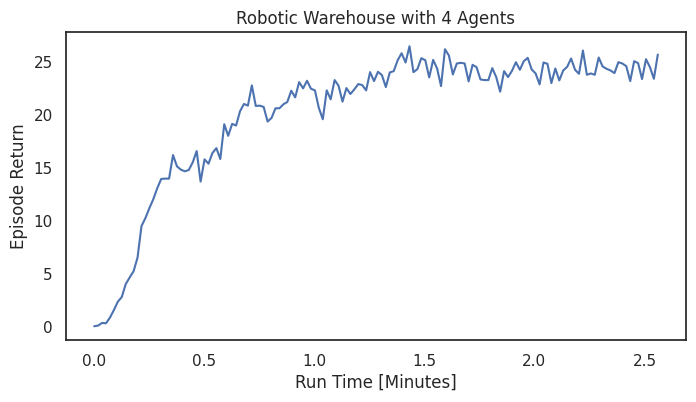

MAPPO experiment completed


In [29]:
start_time=time.time()
for i in range(config["arch"]["num_evaluation"]):
    # Train.
    learner_output = learn(learner_state)
    jax.block_until_ready(learner_output)

    # Prepare for evaluation.
    trained_params = jax.tree_util.tree_map(
            lambda x: x[:, 0, ...],
            learner_output.learner_state.params.actor_params,  # Select only actor params
    )
    rng_e, *eval_rngs = jax.random.split(rng_e, n_devices + 1)
    eval_rngs = jnp.stack(eval_rngs)
    eval_rngs = eval_rngs.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_rngs)
    jax.block_until_ready(evaluator_output)
    ep_returns=plot_performance(evaluator_output, ep_returns, start_time)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params= jax.tree_util.tree_map(
    lambda x: x[0, 0, ...], learner_output.learner_state.params.actor_params
)
print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

#### Rendering

Now let's render one episode using the trained system

> Note: Creating a complete episode animation can be time-consuming. To address this, we offer a parameter named `max_steps` for the `render_one_episode` function. This parameter determines the number of states displayed in the GIF. Please note that a full episode usually consists of 500 steps.

In [30]:
render_one_episode(config, trained_params)

MovieWriter ffmpeg unavailable; using Pillow instead.


EPISODE RETURN: 88.0
EPISODE LENGTH:500


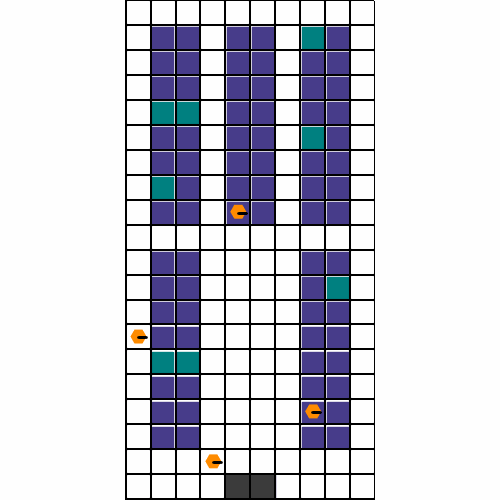

In [31]:
import IPython
from IPython.display import Image
Image(filename='/content/rware.gif',embed=True)